# Imports

In [2]:
import numpy             as np
import pandas            as pd
import pickle
import seaborn           as sns
import psycopg2          as pg
import scikitplot        as skplt
import matplotlib.pyplot as plt

from IPython.display     import Image

from sklearn             import preprocessing   as pp
from sklearn             import model_selection as ms
from sklearn             import ensemble        as en
from sklearn             import neighbors       as nh
from sklearn             import linear_model    as lm
from lightgbm            import LGBMClassifier

In [10]:
# configurações globais
sns.set_theme()                                                   # gráfico
plt.rcParams['figure.figsize'] = [20, 12]                         # gráfico

## Funções

In [31]:
def precision_at_k(data, k=2000):
    # Precision Top K
    data = data.reset_index(drop=True)

    # create ranking
    data['ranking'] = data.index + 1

    # precision at k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']


def recall_at_k(data, k=2000):
    # Recall Top K
    data = data.reset_index(drop=True)

    # create ranking
    data['ranking'] = data.index + 1

    # precision at k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

def performance(data, yhat, k=2000):
    # score
    data['score'] = yhat[:,1].tolist()

    # ordenação pelo score
    data = data.sort_values('score', ascending=False)

    # Precision at K
    precision_at = precision_at_k(data, k)
    print(f'Precision at {k}: {precision_at}')

    # Recall at K
    recall_at = recall_at_k(data, k)
    print(f'Recall at {k}: {recall_at}')


# 1 Coleta dos Dados

In [19]:
# Credenciais
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

In [20]:
conn = pg.connect(user = username,
                  password = password,
                  host = host,
                  port = port,
                  database = database)

OperationalError: could not translate host name "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com" to address: Name or service not known


## 1.1 Consulta do Schema

In [ ]:
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute(query_schema)

record = cursor.fetchall()
cursor.close()
conn.close()

In [ ]:
record

## 1.2 Consulta das Tabelas

In [ ]:
cursor = conn.cursor()

query_table = """
select tablename
from pg_catalog.pg_tables pt 
where  schemaname = 'pa004'
"""

cursor.execute(query_table)
record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

## 1.3 Coleta de Dados usando o Psycopg2

In [ ]:
cursor = conn.cursor()

query = """
SELECT
*
FROM pa004.users u
WHERE u.age > 44
LIMIT 10
"""

cursor.execute(query)
record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

In [ ]:
pd.DataFrame(record)

## 1.4 Coleta de Dados usando Pandas

In [ ]:
query = """
SELECT
*
FROM pa004.users u
WHERE u.age > 44
LIMIT 10
"""

pd.read_sql(query, conn)

In [ ]:
query = """
SELECT
*
FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                   LEFT JOIN pa004.insurance i ON (u.id = i.id)
"""

df = pd.read_sql(query, conn)
df.head()

In [ ]:
# Drop das Colunas "id" que estão repetidas
df['id_aux'] = df['id'].apply(np.mean, axis=1)
df = df.drop(columns='id', axis=1)

df.insert(0, 'id', df['id_aux'].astype('int64')) 
df = df.drop(columns='id_aux', axis=1)

In [ ]:
df.head()

In [ ]:
df.to_csv('datasets/data_raw.csv', index=False)

# 2 Análise Descritiva

In [2]:
#df2 = pd.read_csv('datasets/data_raw.csv')
df2 = pd.read_csv('datasets/train.csv')
df2.columns = df2.columns.str.lower()

In [28]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2.1 Dimensões dos dados

In [29]:
print(f'Linhas: {df2.shape[0]}')
print(f'Colunas: {df2.shape[1]}')

Linhas: 381109
Colunas: 12


## 2.2 Tipos das Variáveis

In [30]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 2.3 Checagem de NA's

In [31]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 2.4 Estatística Descritiva

In [32]:
df2.describe()

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [33]:
df2_cat = df2.select_dtypes(include=['object'])
df2_cat.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


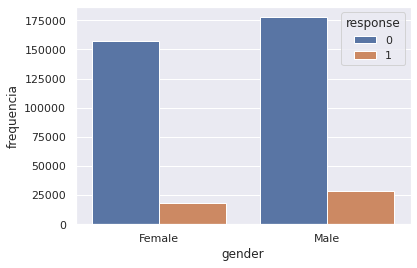

In [34]:
# gender x response
df_aux = df2[['id', 'gender', 'response']].groupby(['gender', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='gender', y='frequencia', hue='response');

<AxesSubplot:xlabel='vehicle_age', ylabel='frequencia'>

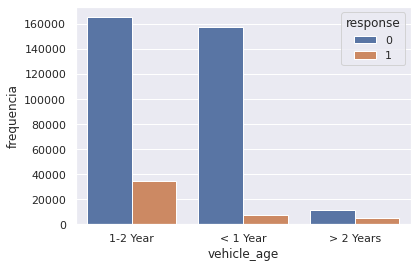

In [35]:
# vehicle_age x response
df_aux = df2[['vehicle_age', 'response', 'id']].groupby(['vehicle_age', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_age', y='frequencia', hue='response')

<AxesSubplot:xlabel='vehicle_damage', ylabel='frequencia'>

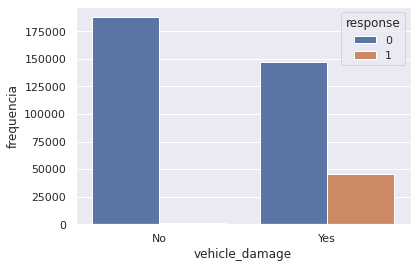

In [36]:
# vehicle_damage x response
df_aux = df2[['vehicle_damage', 'response', 'id']].groupby(['vehicle_damage', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_damage', y='frequencia',hue='response')

# 3 Feature Engineering

In [3]:
df3 = df2.copy()

## 3.1 Mapa Mental de Hipóteses

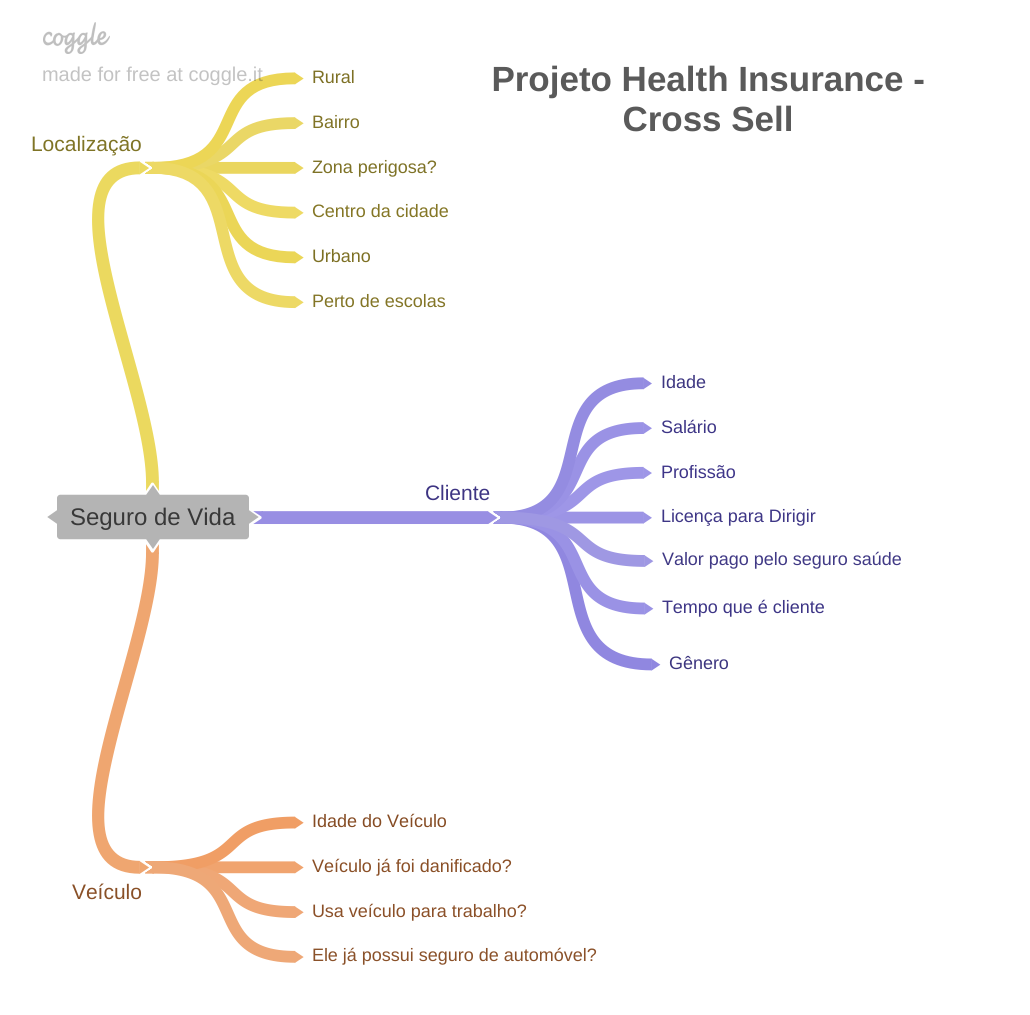

In [22]:
Image('images/Seguro_de_Vida.png')

## 3.2 Criação de Hipóteses

### 3.2.1 Clientes

**H1**: Clientes mais velhos tem mais interesse em obter seguro de automóvel.

**H2**: Clientes mulheres tem mais interesse em obter seguro de automóvel.

**H3**: Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.

**H4**: Clientes que pagaram mais pelo seguro de vida possuem mais interesse em obter seguro de automóvel.

**H5**: Clientes mais antigos possuem mais interesse em obter seguro de automóivel.

### 3.2.2 Veículo

**H6**: Clientes com veículos mais antigos tem menos interesse em obter seguro de automóvel.

**H7**: Clientes com veículos que já foram danificados tem mais interesse em obter seguro de automóvel.

**H8**: Clientes que já possuem seguro de automóvel em outra seguradora possuem menos interesse em obter seguro de automóvel.

**H9**: Clientes que usam o carro para trabalhar possuem mais interesse em obter seguro de automóvel.

### 3.2.3 Localização

Nesse ciclo não temos grandes informações sobre as localizações dos clientes, então não serão expĺoradas hipóteses de negócios para esse atributo. Mas, algumas hipóteses que poderiam ser levantadas, seriam:

**H10**: Clientes que moram na zona urbana possuem mais interesse em obter seguro de automóvel.

**H11**: Clientes que moram em área periféricas possuem menos interesse em obter seguro de automóvel.

**H12**: Clientes que moram em área perto a escolas possuem mais interesse em obter seguro de automóvel.

## 3.3 Feature Engineering

In [4]:
# gender
df3['gender'] = df3['gender'].apply(lambda x: '0' if x == 'Male' else '1')

# vehicle_age
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 0.5 if x == '< 1 Year' else 
                                                        1.5 if x == '1-2 Year' else
                                                        2.5)

# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [10]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,0,44,1,28.0,0,2.5,1,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1.5,0,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2.5,1,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0.5,0,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0.5,0,27496.0,152.0,39,0


# 4 Análise Exploratória dos Dados


In [5]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

<AxesSubplot:xlabel='response', ylabel='id'>

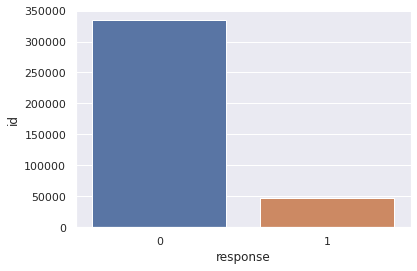

In [8]:
df_aux = df4[['id','response']].groupby('response').count().reset_index()

sns.barplot(data=df_aux, x='response', y='id')

### 4.1.2 Variáveis Numéricas

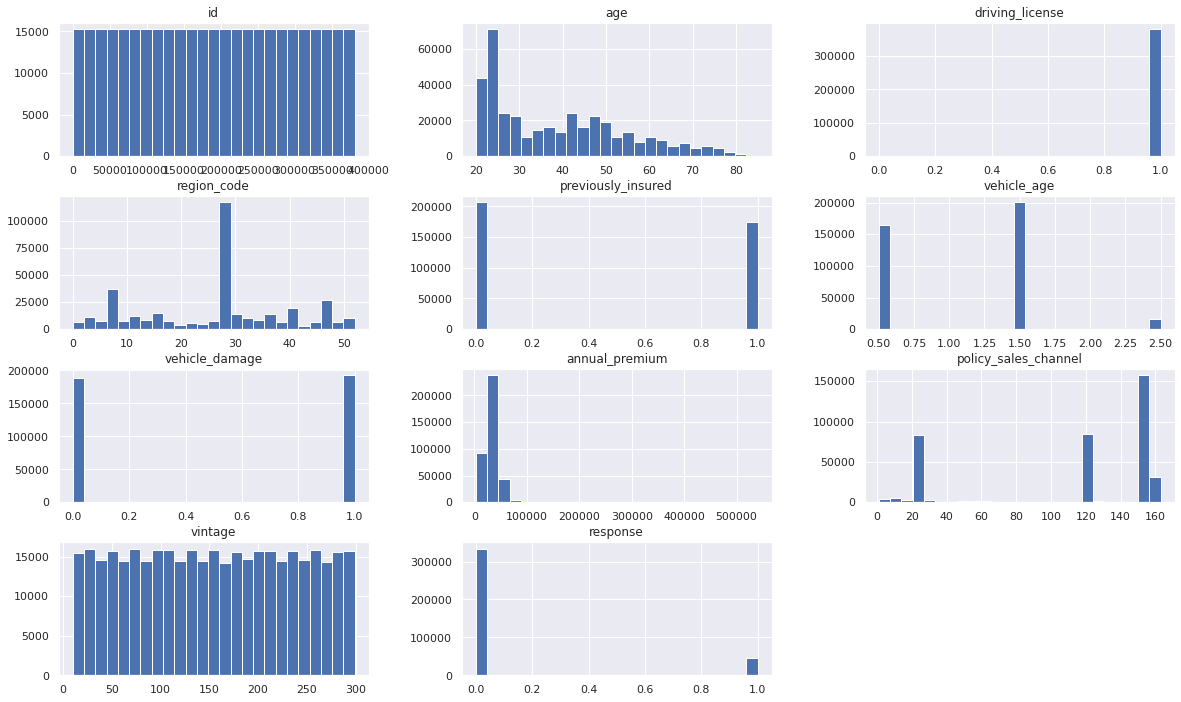

In [11]:
df4_num = df4.select_dtypes(include=['int64', 'float64'])

df4_num.hist(bins=25);

## 4.2 Análise Bivariada

### 4.2.1 H1: Clientes mais velhos tem mais interesse em obter seguro de automóvel.
**Falso**. Clientes na meia idade (entre 30 e 50 anos) possuem mais interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='age', ylabel='response'>

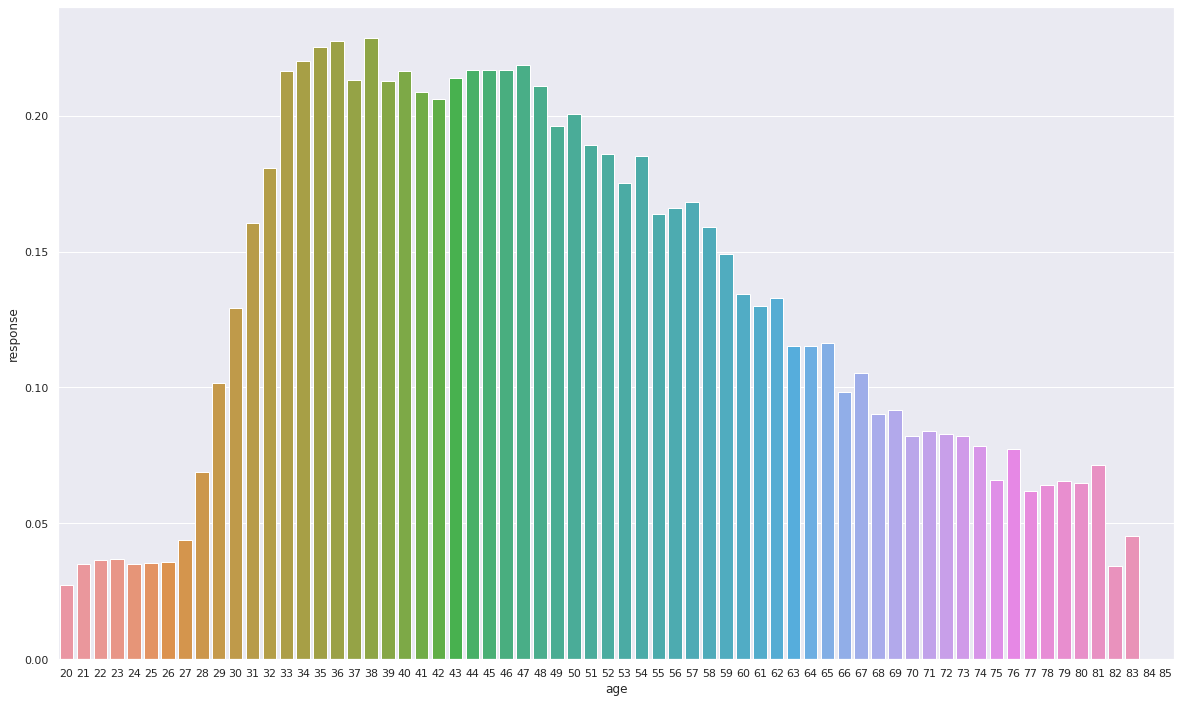

In [25]:
# age x response
df_aux = df4[['age', 'response']].groupby('age').mean().reset_index()

sns.barplot(data=df_aux, x='age', y='response')

### 4.2.2 H2: Clientes mulheres tem mais interesse em obter seguro de automóvel.
**Falso**. Clientes mulheres tem menos interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='gender', ylabel='response'>

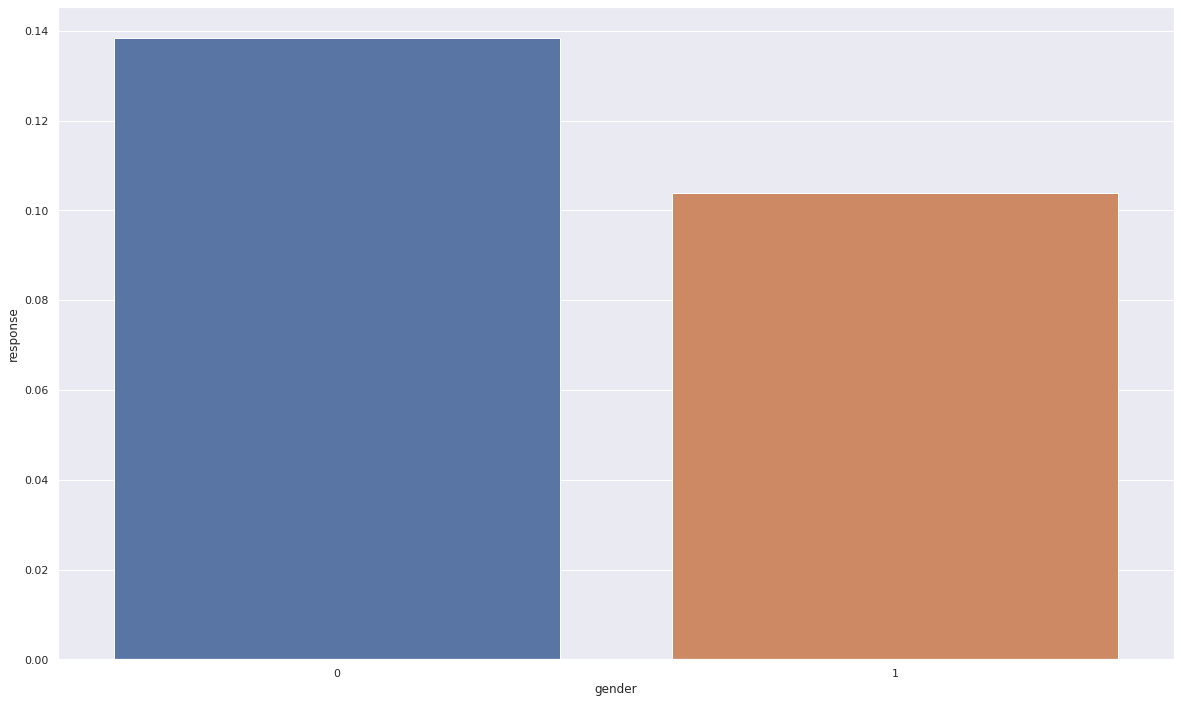

In [24]:
# gender x response
df_aux = df4[['gender', 'response']].groupby('gender').mean().reset_index()

sns.barplot(data=df_aux, x='gender', y='response')

### 4.2.3 H3: Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.
**Verdadeiro**. Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='driving_license', ylabel='response'>

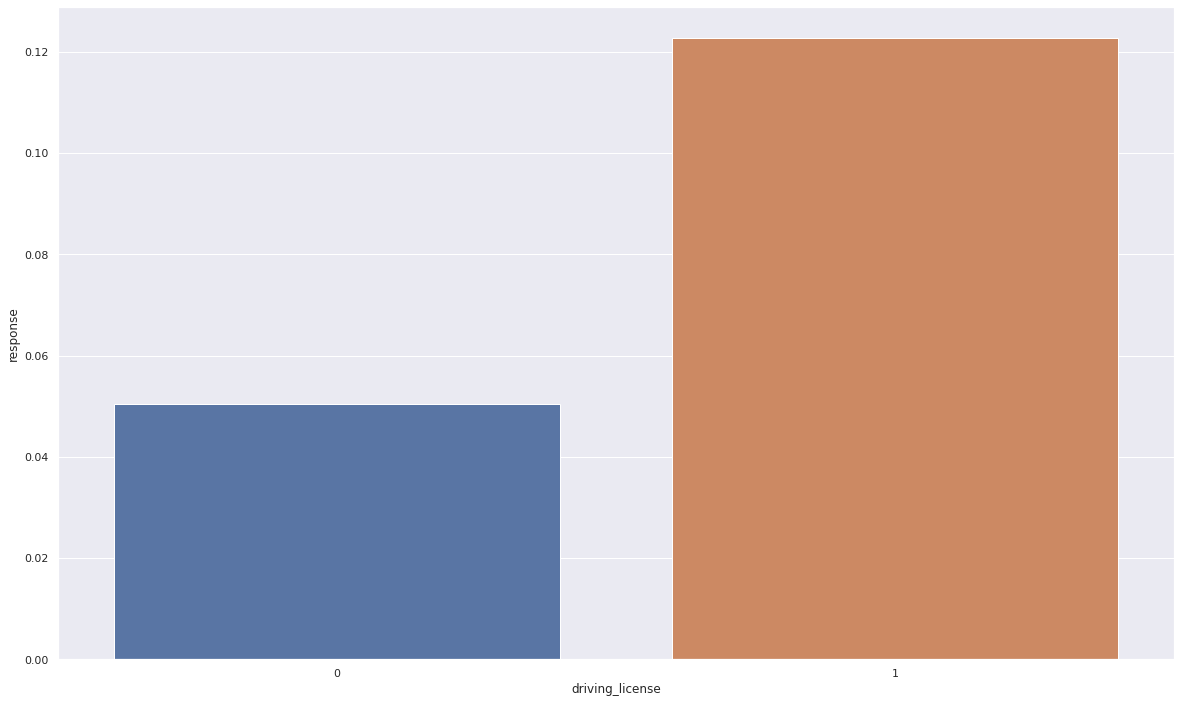

In [23]:
# driving_license x response
df_aux = df4[['driving_license', 'response']].groupby('driving_license').mean().reset_index()

sns.barplot(data=df_aux, x='driving_license', y='response')

### 4.2.4 H4: Clientes que pagaram mais pelo seguro de vida possuem mais interesse em obter seguro de automóvel.

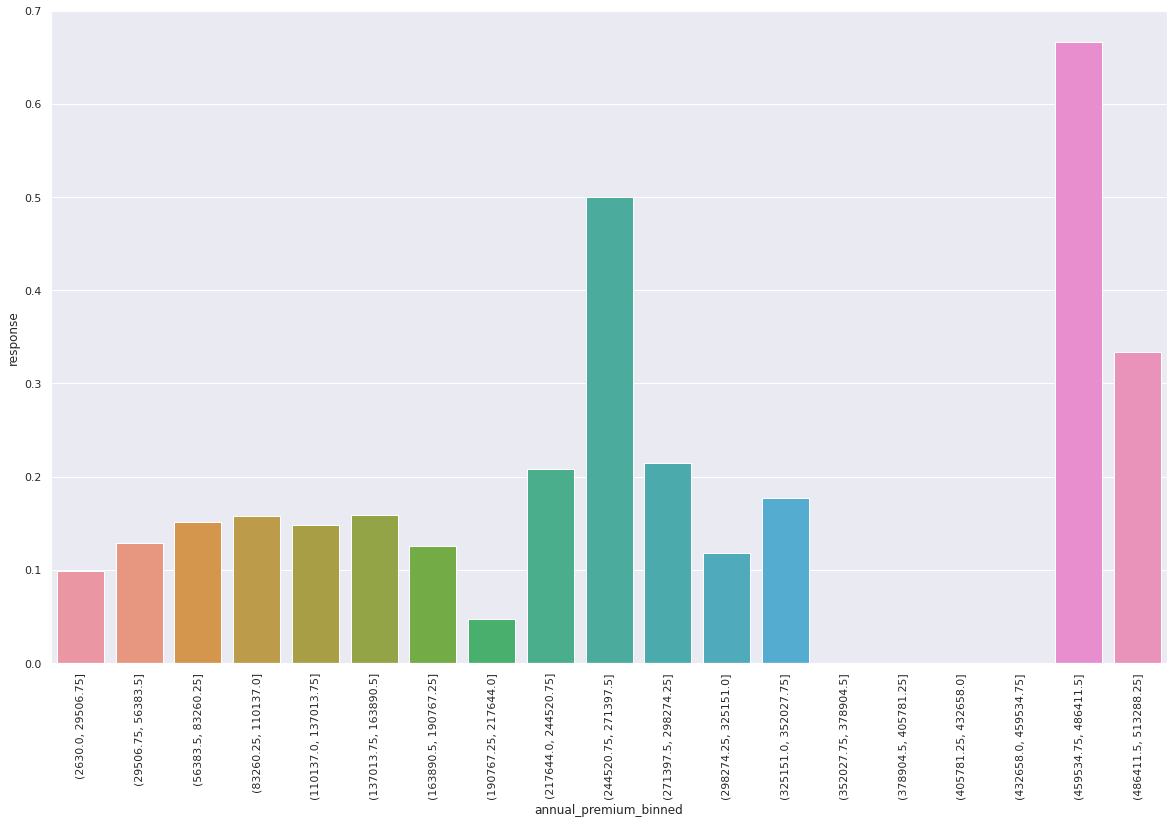

In [22]:
# annual_premium x response
# df_aux = df4[['annual_premium', 'response']].groupby('annual_premium').count().reset_index()

x0 = df4['annual_premium'].min()
xf = df4['annual_premium'].max()

b = list(np.arange(x0, xf, (xf-x0)/20))
df4['annual_premium_binned'] = pd.cut(df4['annual_premium'], bins=b)
df_aux = df4[['annual_premium_binned', 'response']].groupby('annual_premium_binned').mean().reset_index()

sns.barplot(data=df_aux, x='annual_premium_binned', y='response');
plt.xticks(rotation=90);

### 4.2.5 H5: Clientes mais antigos possuem mais interesse em obter seguro de automóvel.
**Falso** Não há diferença significativa com relação ao tempo que o cliente possui o seguro de vida.

<AxesSubplot:xlabel='response', ylabel='vintage_binned'>

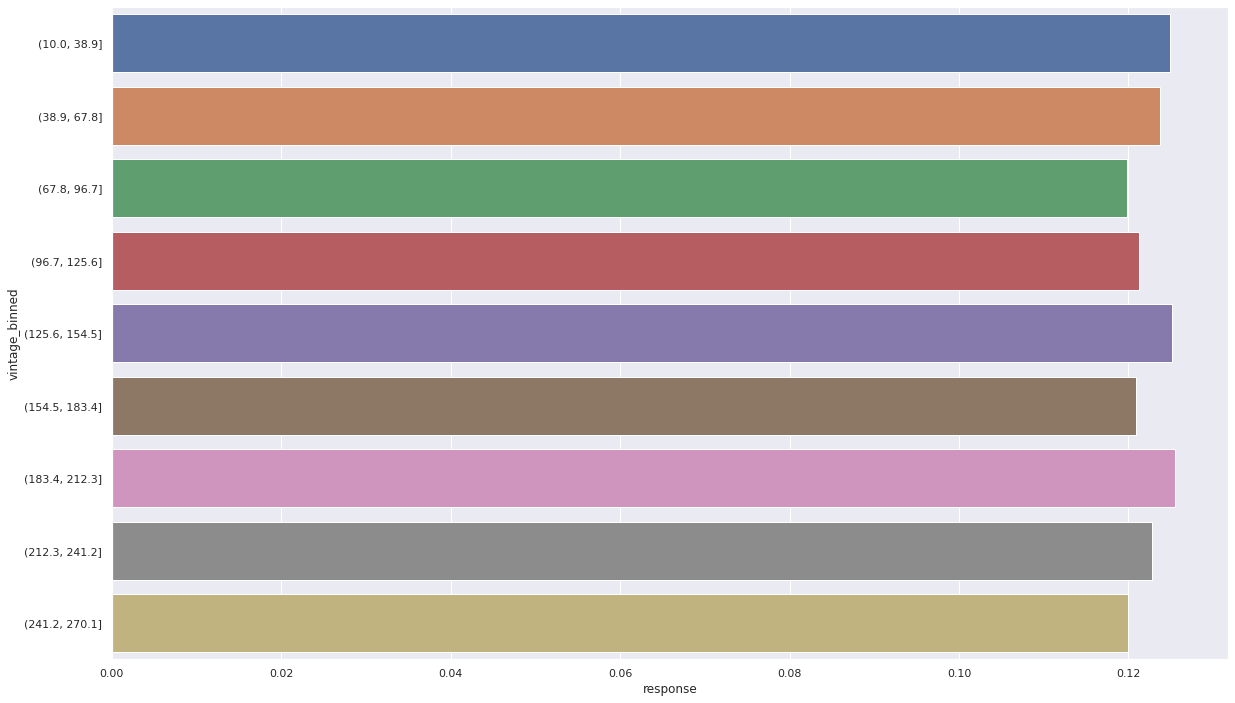

In [39]:
# vintage x response

x0 = df4['vintage'].min()
xf = df4['vintage'].max()

b = list(np.arange(x0, xf, (xf-x0)/10))
df4['vintage_binned'] = pd.cut(df4['vintage'], b)
aux = df4[['vintage_binned', 'response']].groupby('vintage_binned').mean().reset_index()

sns.barplot(data=aux, y='vintage_binned', x='response')


### 4.2.6 H6: Clientes com veículos mais antigos tem menos interesse em obter seguro de automóvel.
**Falso** Clientes com veículos mais antigos tem mais interesse em obter seguro de automóvel

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

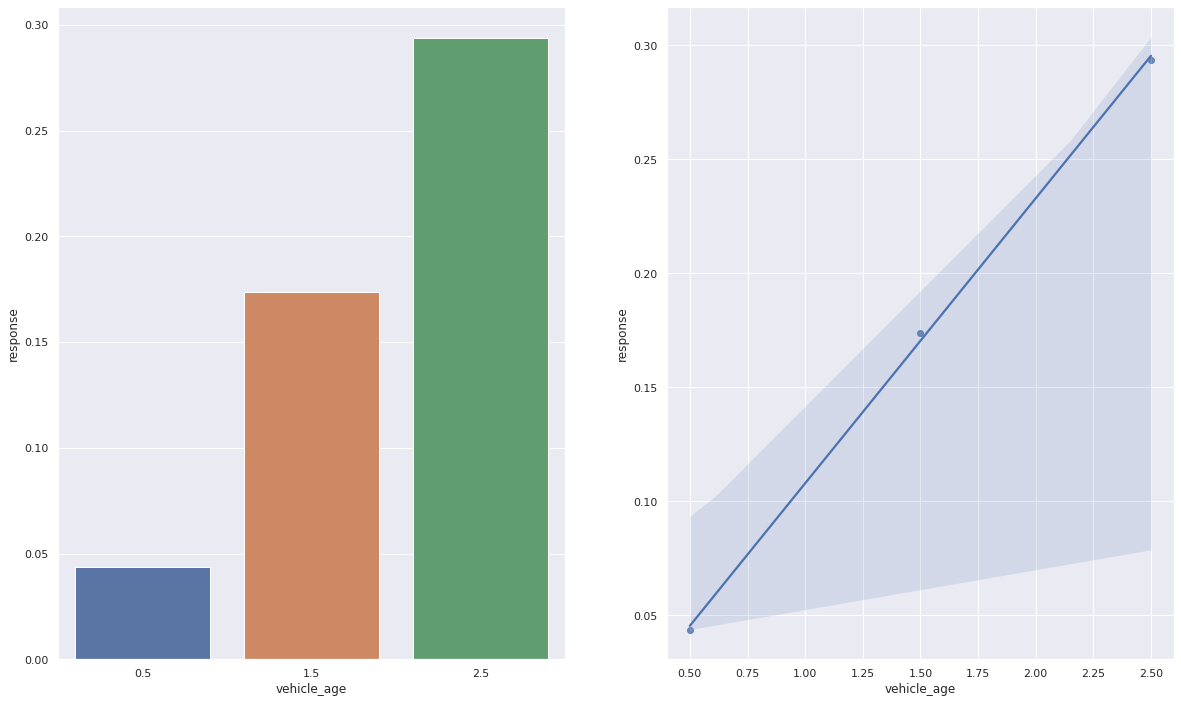

In [41]:
# vehicle_age x response
aux = df4[['vehicle_age', 'response']].groupby('vehicle_age').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data=aux, x='vehicle_age', y='response')

plt.subplot(1, 2, 2)
sns.regplot(data=aux, x='vehicle_age', y='response')

### 4.2.7 H7: Clientes com veículos que já foram danificados tem mais interesse em obter seguro de automóvel.
**Verdade** Clientes com veículos que já foram danificados tem MUITO mais interesse em obter seguro de automóvel.


<AxesSubplot:xlabel='vehicle_damage', ylabel='response'>

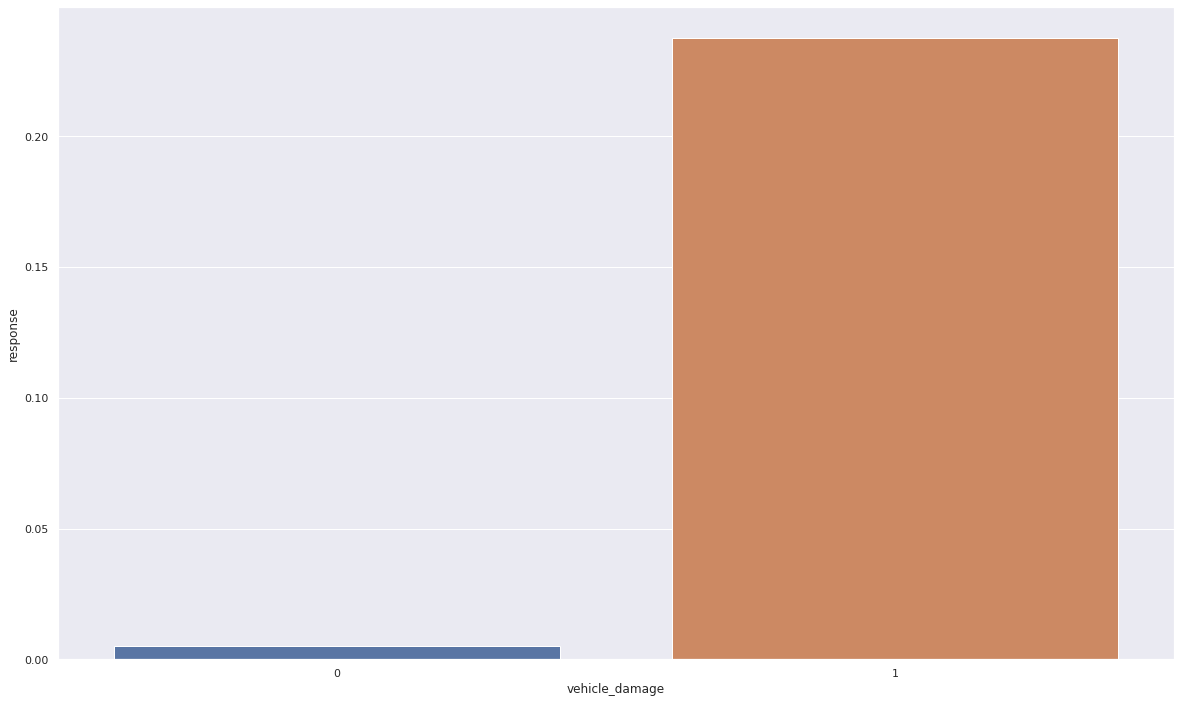

In [47]:
# vehicle_damage x response
aux = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').mean().reset_index()

sns.barplot(data=aux, x='vehicle_damage', y='response')

### 4.2.8 H8: Clientes que já possuem seguro de automóvel em outra seguradora possuem menos interesse em obter seguro de automóvel.
**Verdade** Clientes que já possuem seguro de automóvel em outra seguradora possuem EXTREMAMENTE MENOS interesse em obter um novo seguro.

<AxesSubplot:xlabel='previously_insured', ylabel='response'>

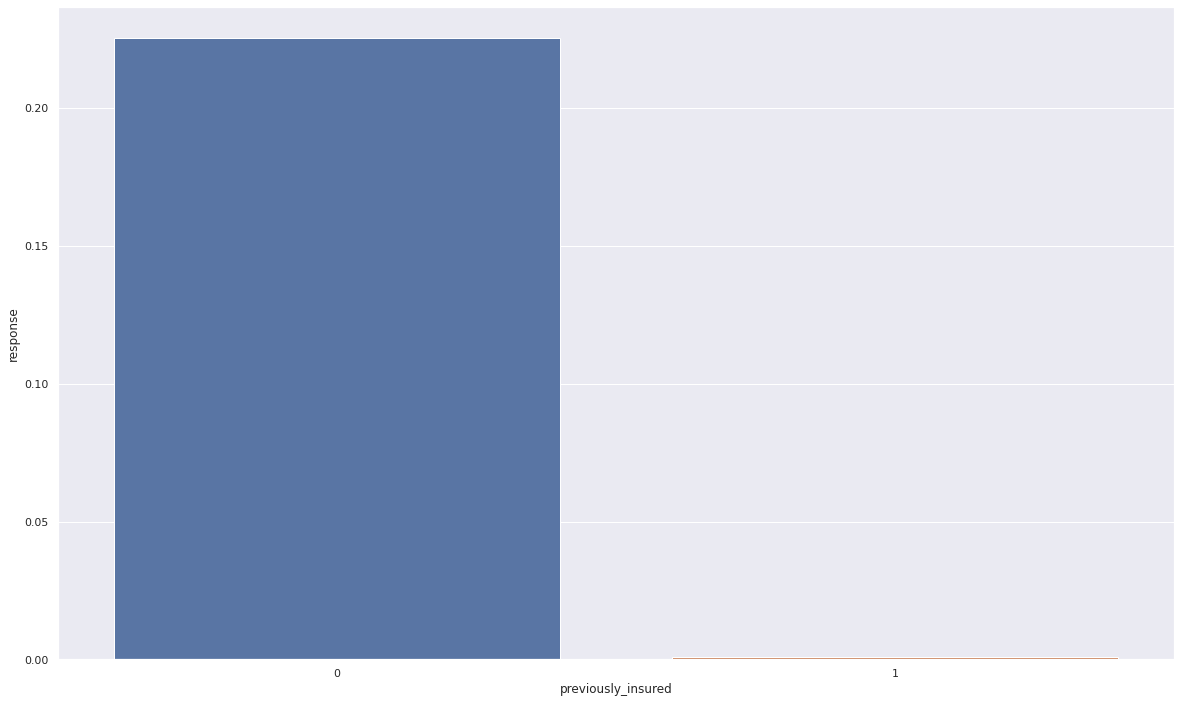

In [50]:
# previously_insured x response
aux = df4[['previously_insured', 'response']].groupby('previously_insured').mean().reset_index()

sns.barplot(data=aux, x='previously_insured', y='response')

# 5 Preparação dos Dados

In [6]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

df5 = pd.concat([X_train, y_train], axis=1)

## 5.1 Padronização

In [7]:
ss = pp.StandardScaler() 

# annual_premium (pois a distribuição é próxima da normal. Não estamos tratando os outliers)
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('parameter/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [8]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age (pois a distribuição não é próxima da normal)
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('parameter/age_scaler.pkl', 'wb'))

# vintage (pois a distribuição não é próxima da normal)
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values) 
pickle.dump(mms_vintage, open('parameter/vintage_scaler.pkl', 'wb'))


## 5.3 Enconder

In [9]:
# region_code - Target Encoding (escolhido) / Frequency Encoding / Weight Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('parameter/target_encode_region_code.pkl', 'wb'))

# vehicle_damage -  One Hot Encoding (escolhido) / Frequency Encoding / Target Encoding / Weight Target Encoding
# df5 = pd.get_dummies(df5, prefix='vehicle_damage', columns=['vehicle_damage'])

# policy_sales_channel - Frequency Encoding / One Hot Encoding / Target Encoding / Weight Target Encoding
fe_encode_policy = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_encode_policy)
pickle.dump(fe_encode_policy, open('parameter/fe_encode_policy.pkl', 'wb'))


In [16]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,1,0.292308,1,0.070151,0,1.5,1,1.294417,0.003309,0.750865,1
116248,116249,0,0.276923,1,0.109796,0,1.5,1,-0.436638,0.209638,0.065744,0
255005,255006,0,0.030769,1,0.074305,1,0.5,0,0.854640,0.353472,0.539792,0
317474,317475,1,0.046154,1,0.122946,1,0.5,0,-0.083449,0.010050,0.923875,0
344212,344213,0,0.553846,1,0.100978,0,2.5,1,-1.619422,0.015901,0.501730,0


## 5.4 Validação da Preparação

In [10]:
# annual premium
X_test['annual_premium'] = ss.transform(X_test[['annual_premium']].values)

# age
X_test['age'] = mms_age.transform(X_test[['age']].values)

# vintage 
X_test['vintage'] = mms_vintage.transform(X_test[['vintage']].values)

# region_code
X_test['region_code'] = X_test['region_code'].map(target_encode_region_code)

# vehicle_damage
# X_test = pd.get_dummies(X_test, prefix='vehicle_damage', columns=['vehicle_damage'])

# policy_sales_channel
X_test['policy_sales_channel'] = X_test['policy_sales_channel'].map(fe_encode_policy)

X_test = X_test.fillna(0)

# X_test.head()

In [18]:
X_test.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
dtype: int64

# 6 Seleção dos Atributos

In [11]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# data preparation
X_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(X_train_n, y_train_n)


ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature ranking:
                feature  importance
0               vintage    0.280894
0        annual_premium    0.248784
0                   age    0.153679
0           region_code    0.106334
0        vehicle_damage    0.079504
0  policy_sales_channel    0.060078
0    previously_insured    0.047978
0           vehicle_age    0.016770
0                gender    0.005482
0       driving_license    0.000498


ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (10).

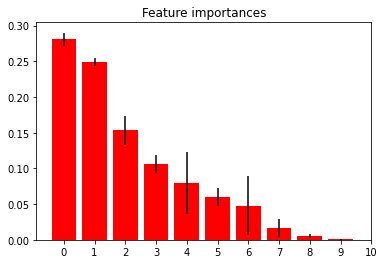

In [12]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i,j in zip(X_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# plot the imputity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

# 7 Machine Learning

In [13]:
X_test2 = X_test.copy()

cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

X_train = df5[cols_selected]
X_test = X_test[cols_selected]

## 7.1 KNN

In [14]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model_training
knn_model.fit(X_train, y_train)

# model prediction - Poder de Generalização
yhat_knn = knn_model.predict_proba(X_test)

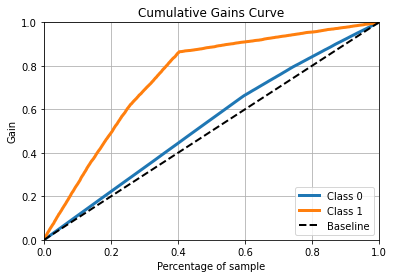

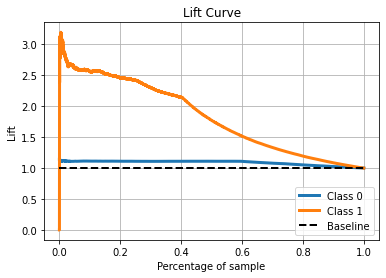

In [15]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_knn);

## 7.2 Regressão Logística

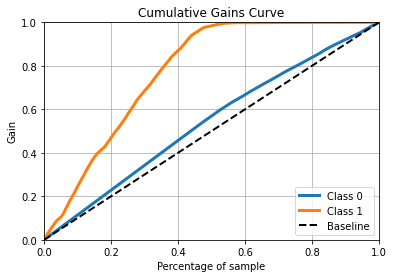

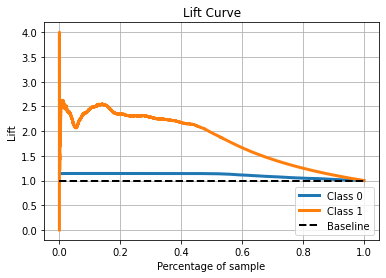

In [16]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(X_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(X_test)

# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_lr);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_lr);

## 7.3 Extra Tree

In [21]:
#  model
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)

# model training
et.fit(X_train, y_train)

# model prediction
yhat_et = et.predict_proba(X_test)


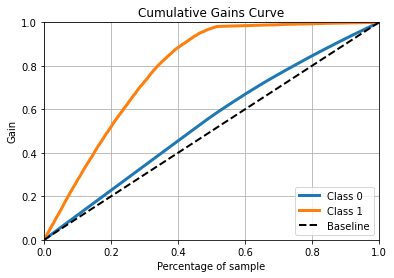

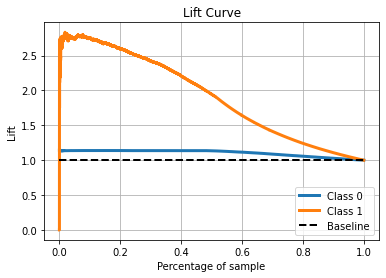

In [18]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_et);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_et);

## 7.4 Random Forest

In [19]:
# model
rf = en.RandomForestClassifier(random_state=42)

# model training
rf.fit(X_train, y_train)

# predict
yhat_rf = rf.predict_proba(X_test)

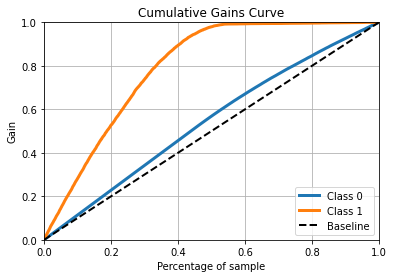

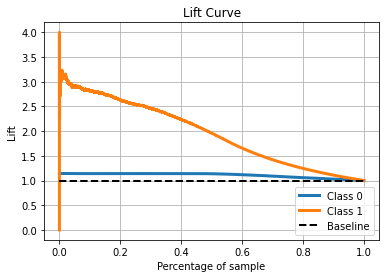

In [20]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_rf);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_rf);

## 7.5 Light Gradiente Boost Machine (LGBM)

In [35]:
# model
lgbm_model = LGBMClassifier(random_state=42)

# model training
lgbm_model.fit(X_train, y_train)

# predict
yhat_lgbm = lgbm_model.predict_proba(X_test)
pickle.dump(lgbm_model, open('model/lgbm_model.pkl', 'wb'))

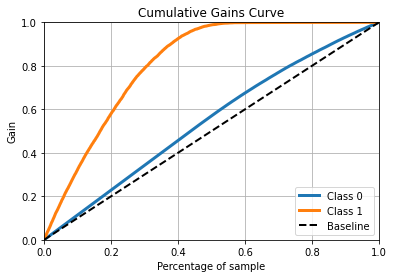

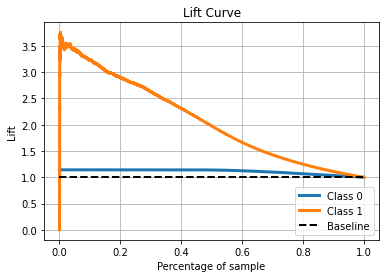

In [36]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_lgbm);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_lgbm);

# 8 Performance do Modelo

In [33]:
# data copy
df8 = pd.concat([X_test2['id'], X_test], axis=1)
df8['response'] = y_test.copy()
df8 = df8.reset_index(drop=True)

## 8.1 KNN

In [52]:
performance(df8, yhat_knn, k=2000)

Precision at 2000: 0.31384307846076964
Recall at 2000: 0.065945605376457


## 8.2 Regressão Logística

In [53]:
performance(df8, yhat_lr, k=2000)

Precision at 2000: 0.25737131434282856
Recall at 2000: 0.05407959676572509


## 8.3 Extra Tree

In [54]:
performance(df8, yhat_et, k=2000)

Precision at 2000: 0.3213393303348326
Recall at 2000: 0.06752073926283735


## 8.4 Random Forest

In [59]:
performance(df8, yhat_rf, k=2000)

Precision at 2000: 0.351824087956022
Recall at 2000: 0.0739262837341174


## 8.5 Light Gradient Boost Machine

In [34]:
performance(df8, yhat_lgbm, k=2000)

Precision at 2000: 0.4362818590704648
Recall at 2000: 0.09167279218733593


# 9 Deploy do Modelo em Produção


## 9.1 Classe HealthInsurance

In [49]:
import pickle
import pandas as pd
import numpy as np

class HealthInsurance(object):
    
    def __init__(self):
        self.path = '/home/jonas/Documentos/repos/health_insurance_cross_sell/parameter/'
        self.age_scaler                = pickle.load(open(self.path + 'age_scaler.pkl', 'rb'))
        self.annual_premium_scaler     = pickle.load(open(self.path + 'annual_premium_scaler.pkl', 'rb'))
        self.fe_encode_policy          = pickle.load(open(self.path + 'fe_encode_policy.pkl', 'rb'))
        self.target_encode_region_code = pickle.load(open(self.path + 'target_encode_region_code.pkl', 'rb'))
        self.vintage_scaler            = pickle.load(open(self.path + 'vintage_scaler.pkl', 'rb'))
    
    def data_cleaning(self, data):
        data.columns = data.columns.str.lower()
        
        return data
    
    def feature_engineering(self, data):
        # gender
        data['gender'] = data['gender'].apply(lambda x: '0' if x == 'Male' else '1')

        # vehicle_age
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 0.5 if x == '< 1 Year' else 
                                                                  1.5 if x == '1-2 Year' else
                                                                  2.5)

        # vehicle damage
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        return data
    
    def data_preparation(self, data):
        
        # annual_premium (pois a distribuição é próxima da normal. Não estamos tratando os outliers)
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)

        # age (pois a distribuição não é próxima da normal)
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # vintage (pois a distribuição não é próxima da normal)
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values) 

        # region_code - Target Encoding (escolhido) / Frequency Encoding / Weight Target Encoding
        data['region_code'] = data['region_code'].map(self.target_encode_region_code)

        # policy_sales_channel - Frequency Encoding / One Hot Encoding / Target Encoding / Weight Target Encoding
        data['policy_sales_channel'] = data['policy_sales_channel'].map(self.fe_encode_policy)
        
        # Se tiver algum Na, completa com 0
        data.fillna(0)
        
        # colunas selecionadas    
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

        return data[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # model predition
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['score'] = pred[1]
        
        return original_data.to_json(orient='records', date_format='iso')   

## 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance
import numpy

path = '/home/jonas/Documentos/repos/health_insurance_cross_sell/'
model = pickle.load(open(path + 'model/random_forest.pkl', 'rb'))

# inicialização da API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    print('entrou 0')
    if test_json:  # se existir data
        print(type(test_json))
        print(test_json)
        if isinstance(test_json, dict): # se for uma única linha
            print('entrou 2')
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: # se for múltiplas linhas
            print('entrou 3')
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())            
            
        # instanciando a Classe HealthInsurance
        pipeline = HealthInsurance()
        
        # limpeza dos dados
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # preparação dos dados
        df3 = pipeline.data_preparation(df2)
        
        # predição
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
    
if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

## 9.3 API Tester

In [3]:
import requests

In [4]:
# loading conjunto de dados de teste
df_test_raw = pd.read_csv('/home/jonas/Documentos/repos/health_insurance_cross_sell/datasets/test.csv')
# df_test_raw = df_test_raw.sample(10)

In [5]:
df_test_id = df_test_raw['id'].copy()
df_test = df_test_raw.drop('id', axis=1)

In [6]:
# converter o dataframe para json
data = json.dumps(df_test.to_dict(orient='records')) 

In [7]:
# API Call
url = 'http://0.0.0.0:5000/predict'

header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, headers=header, data=data)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [8]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
df_result = pd.concat([df_test_raw, d1['score']], axis=1).sort_values('score', ascending=False).reset_index(drop=True)

# 10 Resultados do Negócio

In [9]:
# Com as 20000 primeiras pessoas espera-se atingir 46,52% de todos os interessados
df_result['score'].head(20000).sum() / df_result['score'].sum() 

0.4651712531028598

In [10]:
# comparando com o modelo aleatório
20000 / df_result.shape[0]

0.15743444823161756

In [12]:
(df_result['score'].head(20000).sum() / df_result['score'].sum() ) / (20000 / df_result.shape[0]) - 1

1.9546980240214

Para as 20000 primeiras ligações o modelo aleatório atingirá 15,74% do interessados, enquanto a nossa solução atinge 46,52%. Essa diferença percentual significa um aumento de 195,46% no faturamento.

In [121]:
# Com as 40000 primeiras pessoas espera-se atingit 80,47% de todos os interessados
df_result['score'].head(40000).sum() / df_result['score'].sum() 

0.8046688959615776

In [13]:
# comparando com o modelo aleatório
40000 / df_result.shape[0]

0.3148688964632351

In [14]:
(df_result['score'].head(40000).sum() / df_result['score'].sum() ) / (40000 / df_result.shape[0]) - 1

1.5555680634067732

Para as 40000 primeiras ligações o modelo aleatório atingirá 31,48% do interessados, enquanto a nossa solução atinge 80,46%. Essa diferença percentual significa um aumento de 155,55% no faturamento.

In [122]:
df_result['rank'] = df_result.index + 1

In [123]:
df_result['score_cum_percentege'] = df_result['score'].cumsum() / df_result['score'].sum() 

In [125]:
df_result[(df_result['score_cum_percentege'] > 0.79999) & (df_result['score_cum_percentege'] < 0.80001)]

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score,rank,score_cum_percentege
39648,437369,Female,61,1,8.0,0,1-2 Year,Yes,51933.0,19.0,110,0.207879,39649,0.799992
39649,502820,Male,30,1,36.0,0,< 1 Year,Yes,32368.0,160.0,213,0.207860,39650,0.800006


Para atingir 80% dos interessados é necessário contatar 39650 clientes

# Referências

1. Gráficos: 

- https://www.python-graph-gallery.com/

- https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot

2. Sobre as métricas de Ranking

- https://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples

- https://stats.stackexchange.com/questions/159657/metrics-for-evaluating-ranking-algorithms

- https://archive.siam.org/meetings/sdm10/tutorial1.pdf

- https://brianmcfee.net/papers/mlr.pdf


3. Curvas Ranking e Lift

- https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14


4. Exemplos de Problemas de Métrica

- https://towardsdatascience.com/20-popular-machine-learning-metrics-part-2-ranking-statistical-metrics-22c3e5a937b6


5. Bias and Variance
Book Machine Learning: An Algorithmic Perspective, by Stephen Marsland - Capítulo 02
YouTube: StatQuest


6. Random Forest Model
Book Machine Learning: An Algorithmic Perspective, by Stephen Marsland - Capítulo 13
https://stats.stackexchange.com/questions/262794/why-does-a-decision-tree-have-low-bias-high-variance


7. Paper Original da Random Forest
https://link.springer.com/article/10.1023/A:1010933404324

